In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_filling_half_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(9.999692920925618e-08)

In [4]:
np.max(final_e_difference)

np.float64(9.932758712749568e-09)

In [5]:
np.all(any_bi_fail)==False

np.True_

### Phase Analysis

In [6]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [7]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
nematic_measure = np.zeros(u_mesh.shape)
f_phase = np.zeros(u_mesh.shape)
f_measure = np.zeros(u_mesh.shape)
f_max_measure = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

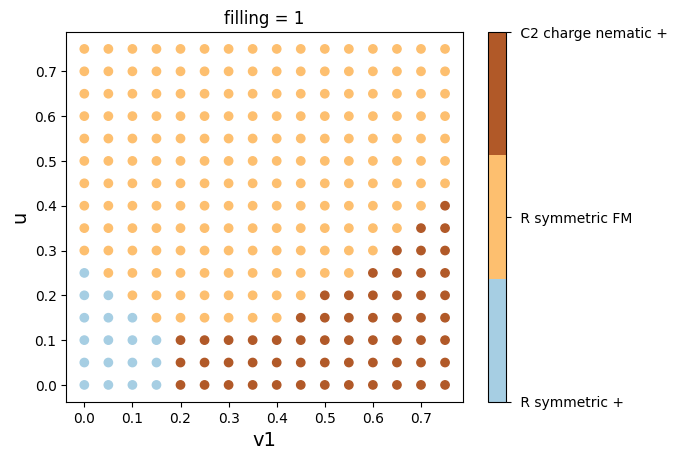

In [8]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

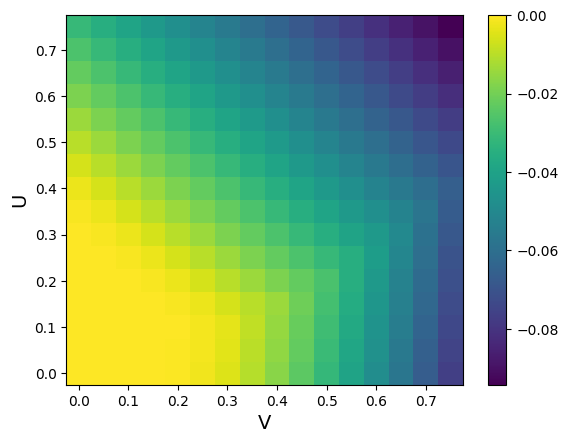

In [9]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [10]:
np.mean(final_iteration)

np.float64(57.537890625)

In [11]:
np.max(final_iteration)

np.int32(452)

In [12]:
np.min(final_iteration)

np.int32(2)

# Obtain a better phase diagram

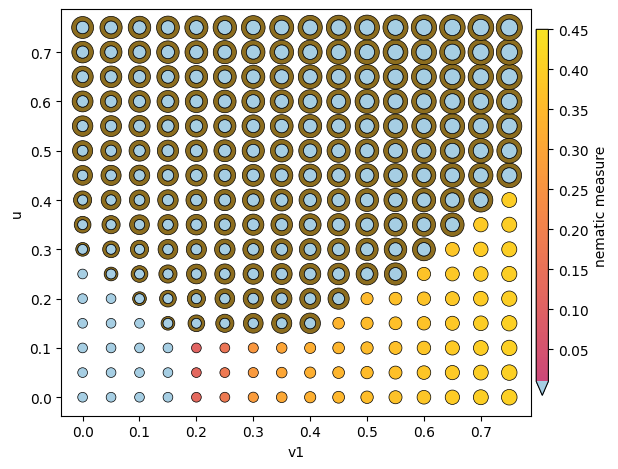

In [22]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(u_mesh.shape)
CFG = PlotConfig(nem_vmax=0.45)
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    v1_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

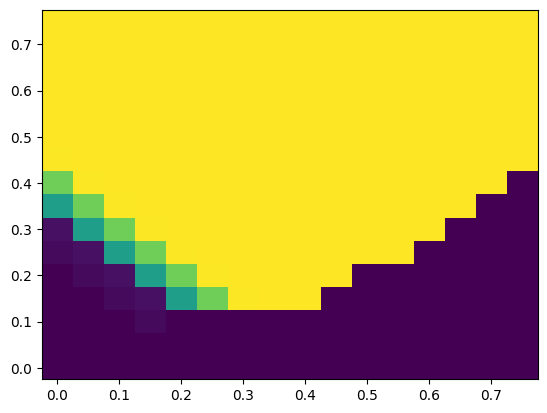

In [23]:
plt.figure()
plt.pcolormesh(v1_mesh,u_mesh,f_max_measure)

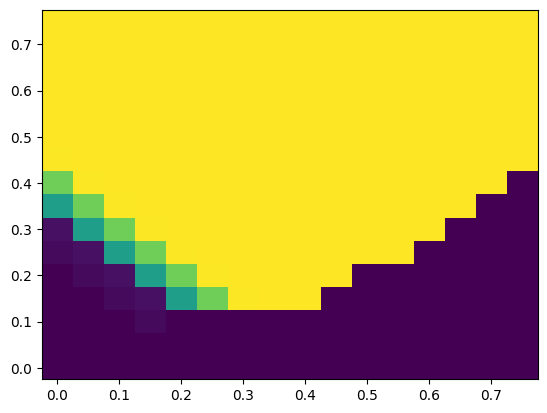

In [24]:
plt.figure()
plt.pcolormesh(v1_mesh,u_mesh,f_measure)

# check the degeneracy

In [25]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase

In [26]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [27]:
degenerate_index

(array([0, 1, 2, 3, 4, 5]),
 array([3, 3, 3, 2, 1, 0]),
 array([6, 9, 7, 7, 7, 7]))

In [28]:
unique_phase_index_degenerate = np.unique(degenerate_state_diagram)
unique_phase_name_degenerate = [phase_1_1[i] for i in np.int_(unique_phase_index_degenerate) if i != -1]

In [29]:
unique_phase_name_degenerate

[' R symmetric FM']

### comment: seems to be natural "degeneracy" at the boundary of phase transition